In [43]:
import scipy.io
import numpy as np
import os
import scipy.signal as signal
import tqdm

from scipy.signal import butter, lfilter

import pandas as pd
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from scipy.stats import entropy
from scipy.stats import special_ortho_group

In [ ]:
def butter_bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs

    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass_filter(lowcut, highcut, fs, order)
    return lfilter(b, a, data, axis=0)

def load_data(path, lowcut= 8, highcut = 30) -> tuple:

    data = scipy.io.loadmat(path)

    # mentioned in bci comp docs
    cnt = data['cnt'].astype(np.float32) * 0.1

    fs = data['nfo']['fs'][0,0]

    cnt = apply_filter(cnt, lowcut, highcut, fs)

    mrk_pos = data['mrk']['pos'][0][0].flatten()
    mrk_label = data['mrk']['y'][0][0].flatten()

    cue_min, cue_max = 0.5, 2.5
    cue_min_samples = int(cue_min * fs)
    cue_max_samples = int(cue_max * fs)
    window = cue_max_samples - cue_min_samples

    num_trials = len(mrk_pos)
    num_channels = cnt.shape[1]
    
    X= np.zeros((num_trials, num_channels, window))

    for i, pos in enumerate(mrk_pos):
        start, end = pos + cue_min_samples, pos + cue_max_samples

        if end > cnt.shape[0]:
            break

        X[i] = cnt[start:end, :].T

    
    y = mrk_label[:X.shape[0]]

    return (X, y, fs)


def get_labeled_inds(X, y):
    valid_indices = ~np.isnan(y)

    x_labeled = X[valid_indices]
    y_labeled = y[valid_indices]

    #trials, channels, window
    #print(x_train.shape)
    #rint(y_train.shape)

    return x_labeled, y_labeled

def extract_CSP(X, y):
    #csp_per_class = 6

    csp = CSP(n_components=6)

    X_csp = csp.fit_transform(X, y)

    print("Transformed CSP data shape:", X_csp.shape)

    return X_csp

def classify_LDA(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4,)
    


    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)  # Train LDA
    y_pred = lda.predict(X_test)  # Predict

    lda_2 = LinearDiscriminantAnalysis()
    scores = cross_val_score(lda_2, X, y, cv=5 )

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test) * 100
    #print(f"LDA Classification Accuracy: {accuracy:.2f}%")
    return accuracy, scores




# Loading Data

In [51]:

file_path_parent = 'data/bca_3_4a'
abs_path = os.path.abspath(file_path_parent)
#print(abs_path)

paths = []
for root, _, files in os.walk(abs_path):

    for file in files:
        paths.append(os.path.join(root,file))


In [46]:
data_per_subject = []

for path in paths:
    
    # tuple of (X, y, fs)
    data = load_data(path)
    data_per_subject.append(data) 
    
print(len(data_per_subject))


C:\Users\jacob\AppData\Local\Temp\ipykernel_18904\3484473891.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cue_min_samples = int(cue_min * fs)
C:\Users\jacob\AppData\Local\Temp\ipykernel_18904\3484473891.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cue_max_samples = int(cue_max * fs)


5


In [47]:
test_data = data_per_subject[0]
X = test_data[0]
print(X.shape)

y = test_data[1]
print(y.shape)

(280, 118, 200)
(280,)


# Extracting Features Test

In [48]:
accuracy_scores = []
cross_val_scores = []
csp_features_per_subject = []
labels_per_subject = []

for data in data_per_subject:

    X = data[0]
    y = data[1]

    x_train, y_train = get_labeled_inds(X,y)
    labels_per_subject.append(y_train)

    X_csp = extract_CSP(x_train, y_train)
    csp_features_per_subject.append(X_csp)

    accuracy, scores = classify_LDA(X_csp, y_train)
    accuracy_scores.append(accuracy)
    cross_val_scores.append(scores)
    #print(accuracy)

Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 118 dim * 9.1e+15  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.
Transformed CSP data shape: (168, 20)
Computing rank from data with rank=None
    Using tolerance 3.6e+02 (2.2e-16 eps * 118 dim * 1.4e+16  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.
Transformed CSP data shape: (224, 20)
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 118 dim * 5.4e+15  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data

In [49]:
print(accuracy_scores)
print(np.mean(cross_val_scores, axis=1))

[97.05882352941177, 97.77777777777777, 100.0, 91.66666666666666, 100.0]
[0.98235294 0.97333333 0.92867647 0.94545455 0.93333333]


In [52]:
x_1 = csp_features_per_subject[0]
x_2 = csp_features_per_subject[2]

y_1 = labels_per_subject[0]
y_2 = labels_per_subject[2]

lda = LinearDiscriminantAnalysis()

lda.fit(x_1, y_1)

y_pred = lda.predict(x_2)

print(accuracy_score(y_2, y_pred))

0.5357142857142857


# Testing the Rotation and Jitter of Features for RL

In [ ]:
import numpy as np
from scipy.linalg import orth


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(X_original, X_transformed, title_original="Original Features", title_transformed="Transformed Features"):
    """
    Plots 2D PCA of CSP features before and after transformation.
    
    Parameters:
    - X_original: (n_samples, n_features) Original CSP features.
    - X_transformed: (n_samples, n_features) Transformed CSP features.
    """
    pca = PCA(n_components=2)
    X_original_pca = pca.fit_transform(X_original)
    X_transformed_pca = pca.transform(X_transformed)

    plt.figure(figsize=(12, 5))

    # Original features
    plt.subplot(1, 2, 1)
    plt.scatter(X_original_pca[:, 0], X_original_pca[:, 1], alpha=0.7)
    plt.title(title_original)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # Transformed features
    plt.subplot(1, 2, 2)
    plt.scatter(X_transformed_pca[:, 0], X_transformed_pca[:, 1], alpha=0.7)
    plt.title(title_transformed)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.show()

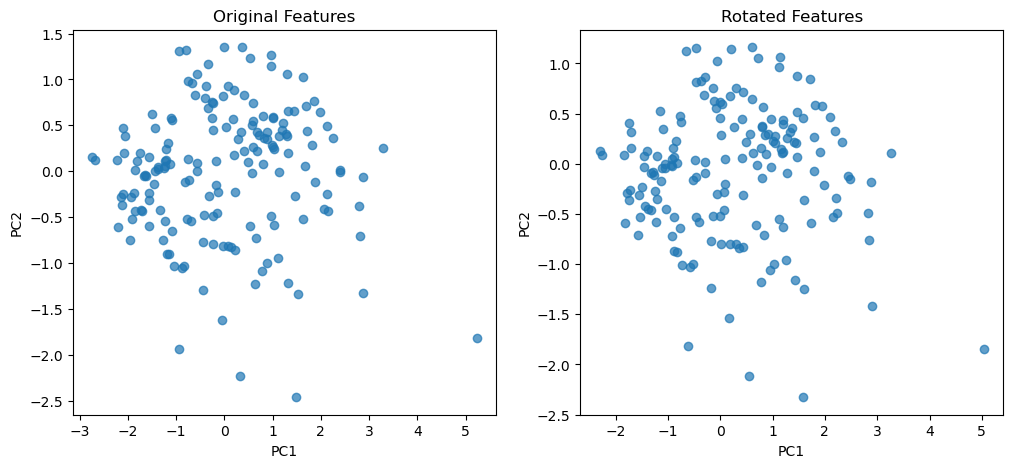

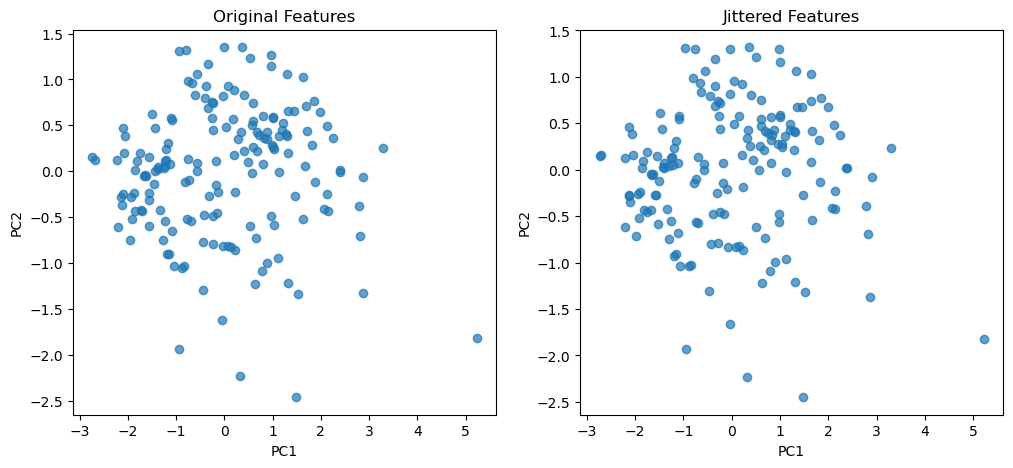

In [19]:
X_rotated = rotate_features(csp_features_per_subject[0], angle=5)
X_jittered = jitter_features(csp_features_per_subject[0], noise_level=0.02)

plot_pca(csp_features_per_subject[0], X_rotated, title_transformed="Rotated Features")
plot_pca(csp_features_per_subject[0], X_jittered, title_transformed="Jittered Features")

In [20]:
from sklearn.manifold import TSNE

def plot_tsne(X_original, X_transformed, title_original="Original Features", title_transformed="Transformed Features"):
    """
    Plots 2D t-SNE of CSP features before and after transformation.
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_combined = np.vstack([X_original, X_transformed])
    X_tsne = tsne.fit_transform(X_combined)

    X_original_tsne = X_tsne[:X_original.shape[0]]
    X_transformed_tsne = X_tsne[X_original.shape[0]:]

    plt.figure(figsize=(12, 5))

    # Original features
    plt.subplot(1, 2, 1)
    plt.scatter(X_original_tsne[:, 0], X_original_tsne[:, 1], alpha=0.7)
    plt.title(title_original)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # Transformed features
    plt.subplot(1, 2, 2)
    plt.scatter(X_transformed_tsne[:, 0], X_transformed_tsne[:, 1], alpha=0.7)
    plt.title(title_transformed)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    plt.show()

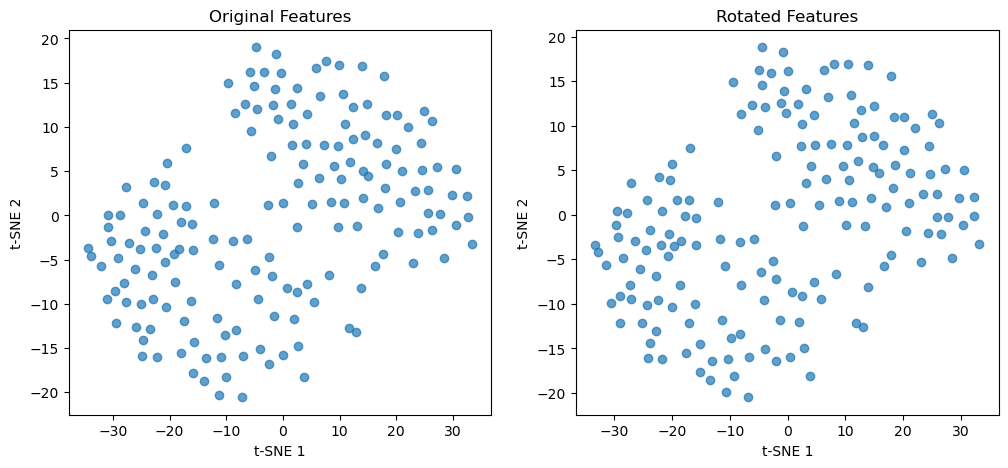

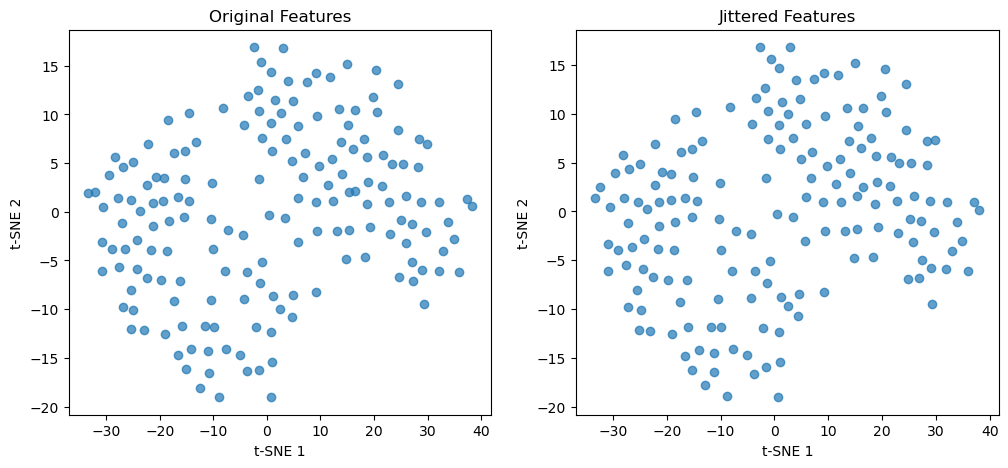

In [21]:
plot_tsne(csp_features_per_subject[0], X_rotated, title_transformed="Rotated Features")
plot_tsne(csp_features_per_subject[0], X_jittered, title_transformed="Jittered Features")

In [22]:
csp_features_per_subject[0].shape
csp_features_per_subject[1].shape

x_1 = X_rotated
x_2 = csp_features_per_subject[2]

y_1 = labels_per_subject[0]
y_2 = labels_per_subject[2]

lda = LinearDiscriminantAnalysis()

lda.fit(x_1, y_1)

y_pred = lda.predict(x_2)

print(accuracy_score(y_2, y_pred))

0.5119047619047619


# Reinforcment Learning 

In [333]:
import gym 
import numpy as np
from gym import spaces
from collections import deque
import random

class EEGFeatureEnv(gym.Env):
    def __init__(self, X_train, y_train, other_subjects_X, other_subjects_y, classifier, max_steps_per_feature=5, decay_factor=0.99, buffer_size=50):

        super(EEGFeatureEnv, self).__init__()

        self.X_train = X_train
        self.y_train = y_train
        self.classifier = classifier

        self.tot_X = other_subjects_X
        self.tot_y = other_subjects_y

        self.curr_ind = 0
        self.feature_step = 0
        self.episode_count = 1
        self.max_steps_per_feature = max_steps_per_feature
        self.decay_factor = decay_factor

        self.best_features = {}

        self.feature_replay_buffer = deque(maxlen=buffer_size)

        self.observation_space = gym.spaces.Box(low=-100000, high=100000, shape=(X_train.shape[1],), dtype=np.float32)

        #self.action_space = gym.spaces.Discrete(10)

        #continous action space for more learning first var in (2, ) for jitter and 
        self.action_space = gym.spaces.Box(low=-550.0, high=550.0, shape=(2,), dtype=np.float32)

    def step(self, action):

        #print(f"Agent took action: {action}")

        rotation_value, jitter_value = action

        scaling_factor = self.decay_factor ** self.episode_count
        rotation_value *= scaling_factor
        jitter_value *= scaling_factor

        feature_vector = self.transformed_X[self.curr_ind].copy()

        #feature_vector = self.apply_jitter(feature_vector, action)
        #feature_vector = self.apply_jitter(feature_vector, action)

        feature_vector = self.apply_rotation_cont(feature_vector, rotation_value)
        #feature_vector = self.apply_jitter_cont(feature_vector, jitter_value)
        
       # transformed_X = self.X_train.copy()

        self.transformed_X[self.curr_ind] = feature_vector
        self.feature_replay_buffer.append(feature_vector.copy())

        accuracy = self.compute_tot_accuracy(self.transformed_X, self.y_train)


        #print(accuracy)

        #reward = (accuracy - self.initial_acc) * 100 - 0.1 * self.compute_kl_divergence(transformed_X) - 0.1 * self.compute_subject_variability(transformed_X)

        reward = accuracy - self.initial_acc * 100 

        if reward > 0:
            reward += 250
        
        else:
            reward -= 50 
        #print(reward)

        if self.curr_ind not in self.best_features or reward > self.best_features[self.curr_ind][1]:
            self.best_features[self.curr_ind] = (feature_vector.copy(), reward)

        #print(f"Step {self.curr_ind}: Accuracy = {accuracy}, Reward = {reward}") 

        self.feature_step += 1
        if self.feature_step >= self.max_steps_per_feature:
            self.feature_step = 0
            self.curr_ind += 1
        
        done = self.curr_ind >= len(self.X_train)

        return feature_vector, reward, done, {}

    def compute_subject_variability(self, transformed_X):
        predictions = [self.classifier.predict(x) for x in self.tot_X]
        std_dev = np.std(predictions, axis=0)  # Variability across subjects
        return np.mean(std_dev)  # Lower is better

    
    from scipy.stats import special_ortho_group

    def apply_rotation(self, feature_vector, action):
        """ Apply small incremental rotations using a random orthogonal matrix. """

        rotation_levels = np.linspace(-10, 10, num=10)  # Rotation angles from -10° to 10°
        rotation_angle = rotation_levels[action]
        
        dim = len(feature_vector)  # Get the feature vector size
    
        if dim < 2:
            return feature_vector  # Can't rotate a single value
        
        # Generate a random rotation matrix for the entire feature space
        dim = len(feature_vector)
        rotation_matrix = special_ortho_group.rvs(dim)
        
        feature_vector = np.dot(rotation_matrix, feature_vector)

        return feature_vector
    
    def apply_rotation_cont(sefl, feature_vector, rotation_value):

        dim = len(feature_vector)
        if dim < 2:
            return feature_vector
        
        rotation_matrix = special_ortho_group.rvs(dim)

        scaled_rotation = np.deg2rad(rotation_value * 10)

        rotated_vector = np.dot(rotation_matrix, feature_vector) * np.cos(scaled_rotation)

        return rotated_vector

    def apply_jitter(self, feature_vector, action):
        
        levels = [0.0,0.8,0.5, 0.1,0.08, 0.05, 0.01,0.008, 0.005, 0.001]
        noise_level = levels[action]

        feature_vector += np.random.normal(0, noise_level, feature_vector.shape)
        return  feature_vector

    def apply_jitter_cont(self, feature_vector, jitter_value):

        noise_level = max(0, jitter_value * 0.1)

        feature_vector += np.random.normal(0, noise_level, feature_vector.shape)

        return feature_vector

    def compute_tot_accuracy(self, transformed_X, y_train):

        self.classifier.fit(transformed_X, y_train)

        tot_acc = []

        for x, label in zip(self.tot_X, self.tot_y):


            y_pred = self.classifier.predict(x)

            accuracy = accuracy_score(y_pred, label)

            tot_acc.append(accuracy)

        
        mean_acc = np.mean(tot_acc)

        #print(mean_acc)

        return mean_acc

    
    def compute_kl_divergence(self, transformed_X):
        self.classifier.fit(transformed_X, self.y_train)
        
        kl_scores = []
        for x in self.tot_X:
            p_train = self.classifier.predict_proba(self.X_train)  # Predicted probabilities on training subject
            p_other = self.classifier.predict_proba(x)  # Predicted probabilities on other subjects
            kl_div = entropy(p_train.mean(axis=0), p_other.mean(axis=0))  # KL divergence
            kl_scores.append(kl_div)

        return np.mean(kl_scores)

    def reset(self):

        #print(self.initial_acc)
        if not hasattr(self, "transformed_X"):  # Only initialize once
            self.transformed_X = self.X_train.copy()

        self.curr_ind = 0
        self.feature_step = 0
        self.episode_count +=1

        if len(self.feature_replay_buffer) > 10 and random.random() < 0.3:
            idx = random.randint(0, len(self.feature_replay_buffer) -1)
            self.transformed_X[self.curr_ind] = self.feature_replay_buffer[idx].copy()


        self.initial_acc = self.compute_tot_accuracy(self.transformed_X, self.y_train)
        #print(self.initial_acc)

        return self.transformed_X[self.curr_ind]
    



In [334]:
from sklearn.preprocessing import StandardScaler
X_train = csp_features_per_subject[0]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

clf = LinearDiscriminantAnalysis()
clf.fit(csp_features_per_subject[0], labels_per_subject[0])

LinearDiscriminantAnalysis()

In [335]:
features_minus_first = csp_features_per_subject[1:4]
labels_minus_first = labels_per_subject[1:4]

# with one subject 5000 - 2% increase at 500 for action
# 2 subjects 40000 iters with rotaion only saw incresases and net pos


print(len(features_minus_first))
env = EEGFeatureEnv(X_train=csp_features_per_subject[0], y_train=labels_per_subject[0],other_subjects_X=features_minus_first, other_subjects_y=labels_minus_first, classifier=clf)



3


In [336]:
from stable_baselines3 import PPO


model = PPO('MlpPolicy', env, 
            learning_rate=1e-4, 
            gamma=0.995,
            gae_lambda=0.9,
            batch_size=256,
            clip_range=0.1,
            verbose=1)
model.learn(total_timesteps=40000)

model.save('eeg_rl_model')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 840      |
|    ep_rew_mean     | -9e+04   |
| time/              |          |
|    fps             | 206      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 840           |
|    ep_rew_mean          | -8.69e+04     |
| time/                   |               |
|    fps                  | 213           |
|    iterations           | 2             |
|    time_elapsed         | 19            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00010764555 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.1           |
|    entropy_loss         | -2.84         |
|    explained_variance   | -0.000544     |


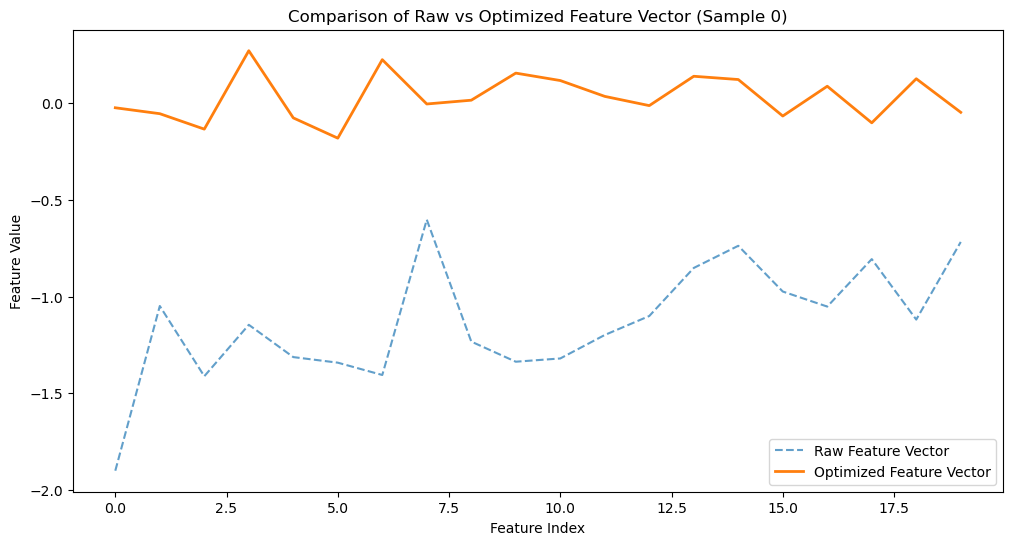

In [337]:
best_transformed_features = np.array([v[0] for v in env.best_features.values()])  # Only feature vectors
raw_features = X_train[list(env.best_features.keys())]  # Corresponding raw vectors

# Compare with a plot
import matplotlib.pyplot as plt

sample_idx = 0  # Choose an index to visualize
plt.figure(figsize=(12, 6))
plt.plot(raw_features[sample_idx], label="Raw Feature Vector", linestyle="--", alpha=0.7)
plt.plot(best_transformed_features[sample_idx], label="Optimized Feature Vector", linewidth=2)
plt.legend()
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title(f"Comparison of Raw vs Optimized Feature Vector (Sample {sample_idx})")
plt.show()

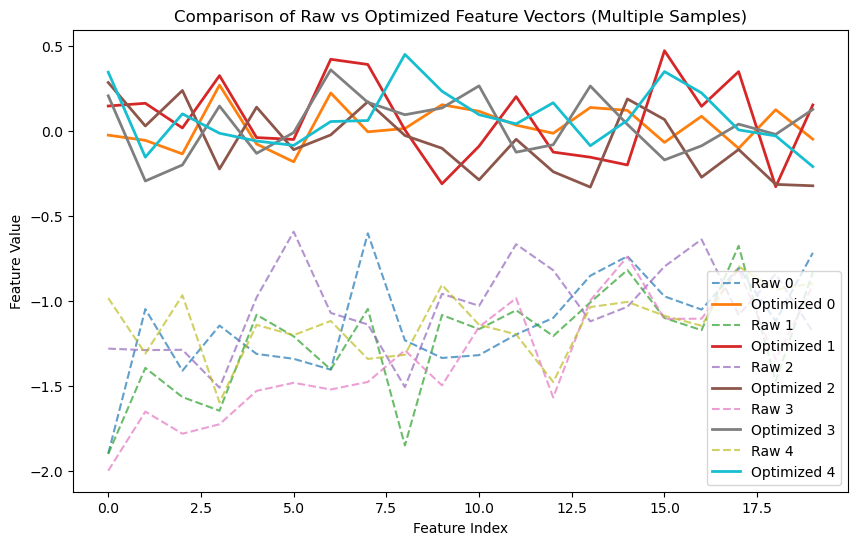

In [338]:
import matplotlib.pyplot as plt
import numpy as np

# Extract best transformed features
best_transformed_features = np.array([v[0] for v in env.best_features.values()])
raw_features = X_train[list(env.best_features.keys())]  # Corresponding raw vectors

# Select a few samples for visualization
num_samples = min(5, len(best_transformed_features))  # Adjust as needed
plt.figure(figsize=(10, 6))

for i in range(num_samples):
    plt.plot(raw_features[i], label=f"Raw {i}", linestyle="--", alpha=0.7)
    plt.plot(best_transformed_features[i], label=f"Optimized {i}", linewidth=2)

plt.legend()
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Comparison of Raw vs Optimized Feature Vectors (Multiple Samples)")
plt.show()

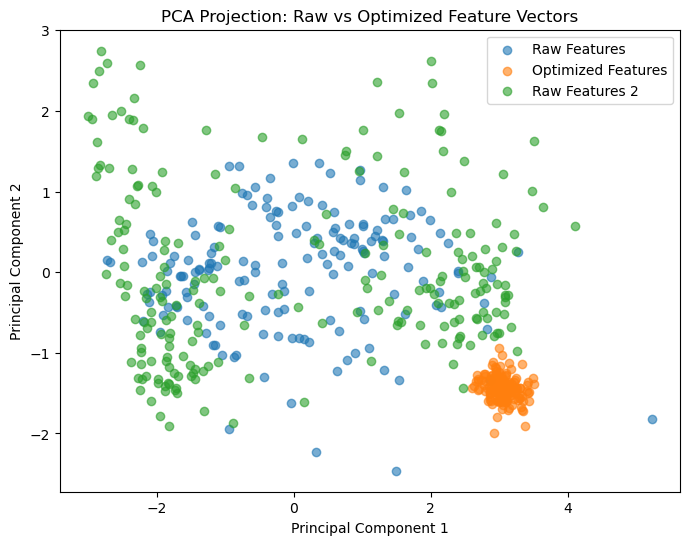

In [339]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)

raw_pca = pca.fit_transform(raw_features)
optimized_pca = pca.transform(best_transformed_features)
raw_pca_2 = pca.fit_transform(features_minus_first[0])

plt.figure(figsize=(8, 6))
plt.scatter(raw_pca[:, 0], raw_pca[:, 1], label="Raw Features", alpha=0.6)
plt.scatter(optimized_pca[:, 0], optimized_pca[:, 1], label="Optimized Features", alpha=0.6)
plt.scatter(raw_pca_2[:, 0], raw_pca_2[:, 1], label="Raw Features 2", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA Projection: Raw vs Optimized Feature Vectors")
plt.show()

In [340]:
clf = LinearDiscriminantAnalysis()
clf2 = LinearDiscriminantAnalysis()
tot_acc = []

X_train = csp_features_per_subject[0]
y_train = labels_per_subject[0]

clf.fit(X_train, y_train)
clf2.fit(best_transformed_features, y_train)

for features, labels in zip(features_minus_first, labels_minus_first):
    
    y_pred_raw = clf.predict(features)

    y_pred_new = clf2.predict(features)

    acc = accuracy_score(y_pred_raw, labels)
    acc_opt = accuracy_score(y_pred_new, labels)

    results = (acc, acc_opt)

    tot_acc.append(results)
    print('test')

print(tot_acc)


test
test
test
[(0.8883928571428571, 0.5), (0.5357142857142857, 0.4880952380952381), (0.6607142857142857, 0.44642857142857145)]


In [341]:
features_minus_first = csp_features_per_subject[1:]
labels_minus_first = labels_per_subject[1:]

clf = LinearDiscriminantAnalysis()
clf2 = LinearDiscriminantAnalysis()
tot_acc = []

X_train = csp_features_per_subject[0]
y_train = labels_per_subject[0]

clf.fit(X_train, y_train)
clf2.fit(best_transformed_features, y_train)

for features, labels in zip(features_minus_first, labels_minus_first):
    
    y_pred_raw = clf.predict(features)

    y_pred_new = clf2.predict(features)

    acc = accuracy_score(y_pred_raw, labels)
    acc_opt = accuracy_score(y_pred_new, labels)

    results = acc_opt-acc


    tot_acc.append((results, acc, acc_opt))
    print('test')

print(tot_acc)


test
test
test
test
[(-0.3883928571428571, 0.8883928571428571, 0.5), (-0.047619047619047616, 0.5357142857142857, 0.4880952380952381), (-0.21428571428571425, 0.6607142857142857, 0.44642857142857145), (0.2857142857142857, 0.07142857142857142, 0.35714285714285715)]


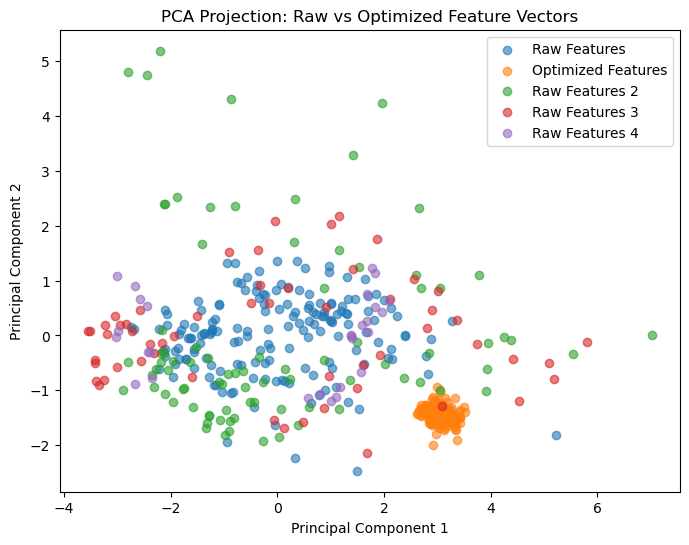

In [342]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)

raw_pca = pca.fit_transform(raw_features)
optimized_pca = pca.transform(best_transformed_features)
raw_pca_2 = pca.fit_transform(features_minus_first[1])
raw_pca_3 = pca.fit_transform(features_minus_first[2])
raw_pca_4 = pca.fit_transform(features_minus_first[3])
#raw_pca_5 = pca.fit_transform(features_minus_first[4])



plt.figure(figsize=(8, 6))
plt.scatter(raw_pca[:, 0], raw_pca[:, 1], label="Raw Features", alpha=0.6)
plt.scatter(optimized_pca[:, 0], optimized_pca[:, 1], label="Optimized Features", alpha=0.6)
plt.scatter(raw_pca_2[:, 0], raw_pca_2[:, 1], label="Raw Features 2", alpha=0.6)
plt.scatter(raw_pca_3[:, 0], raw_pca_3[:, 1], label="Raw Features 3", alpha=0.6)
plt.scatter(raw_pca_4[:, 0], raw_pca_4[:, 1], label="Raw Features 4", alpha=0.6)
#plt.scatter(raw_pca_5[:, 0], raw_pca_5[:, 1], label="Raw Features 2", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA Projection: Raw vs Optimized Feature Vectors")
plt.show()

In [343]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Reduce to 3D for visualization
pca = PCA(n_components=3)

raw_pca = pca.fit_transform(raw_features)
optimized_pca = pca.transform(best_transformed_features)
raw_pca_2 = pca.transform(features_minus_first[1])
raw_pca_3 = pca.transform(features_minus_first[2])
raw_pca_4 = pca.transform(features_minus_first[3])

# Define a color map for binary classification
y_train = labels_per_subject[0]
best_labels = labels_per_subject[0]
color_map = {1: 'red', 2: 'green'}  # 0 = red, 1 = green
color_map_2 = {1: 'blue', 2: 'yellow'} 
raw_colors = [color_map[label] for label in y_train]  # Color each point in raw_features
opt_colors = [color_map_2[label] for label in best_labels]  # Color for optimized features

fig = go.Figure()

# Add scatter plots for each set of features
fig.add_trace(go.Scatter3d(x=raw_pca[:, 0], y=raw_pca[:, 1], z=raw_pca[:, 2],
                            mode="markers", marker=dict(size=5, color=raw_colors),
                            name="Raw Features"))

fig.add_trace(go.Scatter3d(x=optimized_pca[:, 0], y=optimized_pca[:, 1], z=optimized_pca[:, 2],
                            mode="markers", marker=dict(size=5, color=opt_colors),
                            name="Optimized Features"))

# fig.add_trace(go.Scatter3d(x=raw_pca_2[:, 0], y=raw_pca_2[:, 1], z=raw_pca_2[:, 2],
#                             mode="markers", marker=dict(size=5, color=[color_map[label] for label in features_minus_labels[1]]),
#                             name="Raw Features 2"))

# fig.add_trace(go.Scatter3d(x=raw_pca_3[:, 0], y=raw_pca_3[:, 1], z=raw_pca_3[:, 2],
#                             mode="markers", marker=dict(size=5, color=[color_map[label] for label in features_minus_labels[2]]),
#                             name="Raw Features 3"))

# fig.add_trace(go.Scatter3d(x=raw_pca_4[:, 0], y=raw_pca_4[:, 1], z=raw_pca_4[:, 2],
#                             mode="markers", marker=dict(size=5, color=[color_map[label] for label in features_minus_labels[3]]),
#                             name="Raw Features 4"))

# Layout for better visualization
fig.update_layout(scene=dict(
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    zaxis_title="Principal Component 3"
), title="Interactive 3D PCA Projection: Raw vs Optimized Features")

# Show interactive plot
fig.show()


Accuracy on Raw Features: 100.00%
Accuracy on Optimized Features: 75.60%


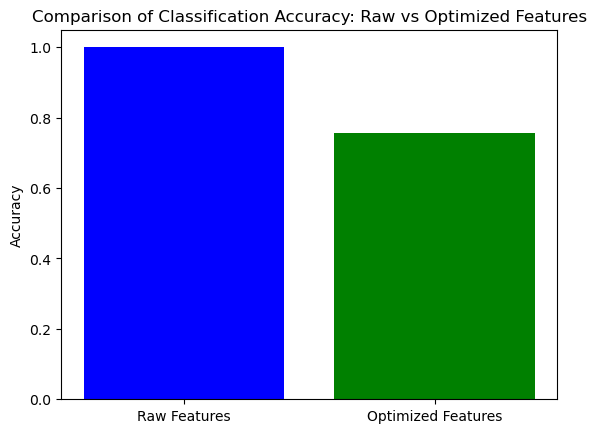

In [330]:
from sklearn.metrics import accuracy_score

y_train = labels_per_subject[0]
# Compute accuracy on original EEG features
classifier.fit(X_train, y_train)
y_pred_raw = classifier.predict(X_train)
raw_accuracy = accuracy_score(y_train, y_pred_raw)

# Compute accuracy on optimized EEG features
classifier.fit(best_transformed_features, y_train)
y_pred_opt = classifier.predict(best_transformed_features)
optimized_accuracy = accuracy_score(y_train, y_pred_opt)

print(f"Accuracy on Raw Features: {raw_accuracy * 100:.2f}%")
print(f"Accuracy on Optimized Features: {optimized_accuracy * 100:.2f}%")

# Bar Plot to Compare
plt.bar(["Raw Features", "Optimized Features"], [raw_accuracy, optimized_accuracy], color=["blue", "green"])
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Accuracy: Raw vs Optimized Features")
plt.show()

In [344]:
# Load trained model
model = PPO.load("eeg_rl_model")

obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)  # RL chooses best feature transformation
    obs, reward, done, _ = env.step(action)
    print(f"Reward: {reward}")


Reward: -110.34523809523809
Reward: -110.3313492063492
Reward: -110.3313492063492
Reward: -110.30704365079364
Reward: -110.33035714285714
Reward: -110.34424603174602
Reward: -110.36011904761904
Reward: -110.3625992063492
Reward: -110.38888888888889
Reward: -110.3938492063492
Reward: -110.43154761904762
Reward: -110.38541666666666
Reward: -110.43501984126983
Reward: -110.39533730158729
Reward: -110.3720238095238
Reward: -110.35912698412699
Reward: -110.42311507936508
Reward: -110.39186507936508
Reward: -110.4126984126984
Reward: -110.3814484126984
Reward: -110.37748015873015
Reward: -110.33928571428571
Reward: -110.40525793650792
Reward: -110.35664682539682
Reward: -110.37450396825396
Reward: -110.36904761904762
Reward: -110.36954365079364
Reward: -110.39980158730158
Reward: -110.39087301587301
Reward: -110.41865079365078
Reward: -110.41567460317461
Reward: -110.4295634920635
Reward: -110.42460317460316
Reward: -110.42311507936508
Reward: -110.42857142857142
Reward: -110.42410714285714


In [345]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.buffers import ReplayBuffer

In [ ]:
model = SAC("MlpPolicy", env, verbose=1, buffer_size=10000, learning_rate=0.001)
model.learn(total_timesteps=50000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 840       |
|    ep_rew_mean     | -7.85e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 48        |
|    time_elapsed    | 69        |
|    total_timesteps | 3360      |
| train/             |           |
|    actor_loss      | 1.23e+03  |
|    critic_loss     | 177       |
|    ent_coef        | 0.225     |
|    ent_coef_loss   | 1.12      |
|    learning_rate   | 0.001     |
|    n_updates       | 3259      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 840       |
|    ep_rew_mean     | -7.97e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 47        |
|    time_elapsed    | 142       |
|    total_timesteps | 6720    